<a href="https://colab.research.google.com/github/dric2018/tunizian_arabizi_sentiments_analysis/blob/main/ZindiArabicSentimentsClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Some utils

In [1]:
%%writefile init.sh

pip install git+https://github.com/eaedk/testing-zindi-package.git -q
pip install pytorch-lightning -q
pip install transformers -U -q

mkdir data/ data/raw/ data/processed/ 

python init.py -username I_am_Zeus_AI -download -data /content/data/raw #Connects the user and download the dataset from zindi

Writing init.sh


In [2]:
%%writefile init.py

import os, sys, gc, glob
import argparse
import pandas as pd
import numpy as np
from zindi import user as zuser
from sklearn.model_selection import train_test_split, StratifiedKFold


parser = argparse.ArgumentParser(description='Logging phase')

parser.add_argument('-username', type=str, help='Your Zindi username')
parser.add_argument('-prefix', type=str, default='/content/drive/My Drive/ZindiArabic_texts_sentiments/', help="***")
parser.add_argument('-data', type=str, default='data/raw/', help="***")

parser.add_argument('-download', action='store_true', help="")
parser.add_argument('-pp', action='store_true', help="")


def download(args):
	user = zuser.Zindian(args.username)
	user.which_challenge
	user.select_a_challenge()
	user.download_dataset(args.data)


def main(parser):
	args = parser.parse_args()

	assert args.download != args.pp, "Can't use --download and --pp together."

	if args.download: download(args)

	if args.pp: 
		preprocessing(args)
		info(args)


if __name__ == '__main__':
	main(parser)

Writing init.py


# Execute utils 

In [3]:
!chmod +x init.sh
!./init.sh

     |████████████████████████████████| 563kB 12.8MB/s 
     |████████████████████████████████| 92kB 12.9MB/s 
     |████████████████████████████████| 829kB 56.3MB/s 
     |████████████████████████████████| 276kB 42.0MB/s 
     |████████████████████████████████| 1.3MB 12.1MB/s 
     |████████████████████████████████| 2.9MB 51.0MB/s 
     |████████████████████████████████| 890kB 46.7MB/s 
     |████████████████████████████████| 1.1MB 43.7MB/s 
Your password
>> 

[ 🟢 ] 👋🏾👋🏾 Welcome I_am_Zeus_AI 👋🏾👋🏾


[ 🔴 ] You have not yet selected any challenge.

__________________________________________________________________________________________________________________________________
|     |              |                  |                    |          
|index|  challenge   |     problem      |       reward       |    id    
|     |              |                  |                    |          
-------------------------------------------------------------------------------------------------

# Imports 

In [4]:
import warnings
warnings.simplefilter('ignore')

In [107]:
import torch 
import torch.nn as nn 
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

import pytorch_lightning as pl 
from pytorch_lightning import seed_everything

import sys 
import os 
import random 

import sklearn 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split
from sklearn.utils.class_weight import compute_class_weight

import seaborn as sns

import transformers
from transformers import AutoTokenizer, AutoModel, AutoConfig, get_linear_schedule_with_warmup

from keras.utils import to_categorical

from tqdm.notebook import tqdm

# Load data

In [6]:
train_data_path = os.path.join('/content/data/raw', 'Train.csv')
test_data_path = os.path.join('/content/data/raw', 'Test.csv')
sample_submission_path = os.path.join('/content/data/raw', 'SampleSubmission.csv')

In [82]:
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)
sub = pd.read_csv(sample_submission_path)

In [83]:
train.tail()

,ID,text,label
69995,ZRSR7TZ,pff bayna beli kbira f wejhakk yakhiii rouhi r...,-1
69996,QNQVEIH,aman lmara jeya zidou t3am9ou fel a7deeth akth...,-1
69997,LJ2K9MD,winha nakhtabha hhhhh,-1
69998,5RZ1T7I,fachel enta w houwa,-1
69999,WZCF7CL,nchla lyouma nesm3ou a5beer bahiya 3la jem3iya,1


In [84]:
test.head()

,ID,text
0,2DDHQW9,barcha aaindou fiha hak w barcha teflim kadhalik
1,5HY6UEY,ye gernabou ye 9a7ba
2,ATNVUJX,saber w barra rabbi m3ak 5ouya
3,Q9XYVOQ,cha3ébbb ta7aaaaannnnnnnnnnn tfouuhh
4,TOAHLRH,rabi y5alihoulek w yfar7ek bih w inchallah itc...


In [85]:
sub.head()

,ID,label
0,2DDHQW9,0
1,5HY6UEY,0
2,ATNVUJX,0
3,Q9XYVOQ,0
4,TOAHLRH,0


In [98]:
test.head()

,ID,text
0,2DDHQW9,barcha aaindou fiha hak w barcha teflim kadhalik
1,5HY6UEY,ye gernabou ye 9a7ba
2,ATNVUJX,saber w barra rabbi m3ak 5ouya
3,Q9XYVOQ,cha3ébbb ta7aaaaannnnnnnnnnn tfouuhh
4,TOAHLRH,rabi y5alihoulek w yfar7ek bih w inchallah itc...


# EDA

In [11]:
train.shape

(70000, 3)

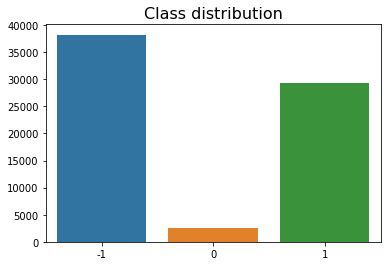

In [12]:
sns.barplot(x=train.label.unique(), y=train.label.value_counts().tolist(), data=train)
plt.title('Class distribution', size=16)
plt.show()

In [13]:
train.describe(include='all')

,ID,text,label
count,70000,70000,70000.000000
unique,70000,70000,NaN
top,99AVJEH,slim embout,NaN
freq,1,1,NaN
mean,NaN,NaN,0.127771
std,NaN,NaN,0.973889
min,NaN,NaN,-1.000000
25%,NaN,NaN,-1.000000
50%,NaN,NaN,1.000000
75%,NaN,NaN,1.000000


In [14]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      70000 non-null  object
 1   text    70000 non-null  object
 2   label   70000 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ MB


In [15]:
tokenizer = AutoTokenizer.from_pretrained("asafaya/bert-base-arabic")

In [16]:
sample_txt = train.text.sample(n=1).values[0]
sample_txt

'andha kwet wala t oumourha chou hak elhadra lekbira'

In [29]:
def show_lengths_distribution(data:pd.DataFrame):  
  interval = np.linspace(start=0, stop=len(data)-1, num=len(data), dtype=np.int32)
  text_lengths = data.text.map(lambda x: len(x)).tolist()
  plt.figure(figsize=(18, 6))
  plt.plot(interval, text_lengths)
  plt.title('Text lengths distribution', size=16)
  plt.show()


def encode_txt(tokenizer, txt, max_len):
  code = tokenizer.encode_plus(text=sample_txt, 
                            max_length=max_len,
                            truncation=True, 
                            add_special_tokens=True)

  ids = code['input_ids']
  mask = code['attention_mask']
  token_type_ids = code['token_type_ids']

  # padding to max_len if necessary
  pad_len = max_len - len(ids)
  ids = ids + ([0] * pad_len)
  mask = mask + ([0] * pad_len)
  token_type_ids = token_type_ids + ([0] * pad_len)
  
  return ids, mask, token_type_ids

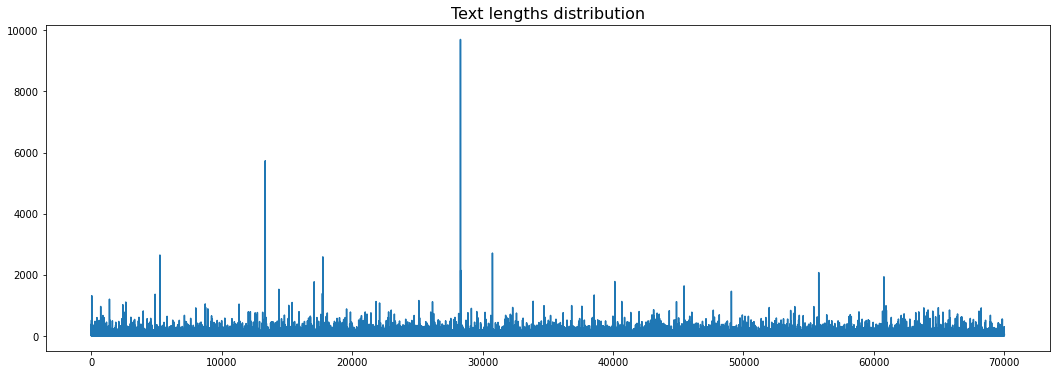

In [86]:
show_lengths_distribution(train)

In [87]:
MAX_LEN = train.text.map(lambda x: len(x)).max()
MIN_LEN = train.text.map(lambda x: len(x)).min()

MIN_LEN, MAX_LEN

(3, 9700)

In [88]:
def delete_outliers(data:pd.DataFrame):
    
  max_len_txts = [i for i, txt in enumerate(data.text.tolist()) if (len(txt) >512 or len(txt) < 10) ]
  
  data.drop(max_len_txts, axis=0, inplace=True)

  return data

In [89]:
train = delete_outliers(train)
len(train)

68473

In [90]:
train = train.reset_index(drop=True)

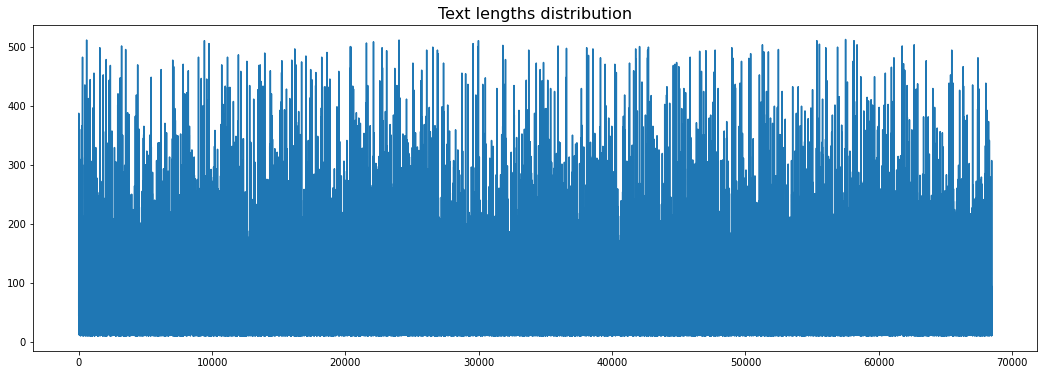

In [91]:
show_lengths_distribution(train)

In [99]:
class ArabiziDataset(Dataset):
  def __init__(self, df=train, tokenizer=tokenizer, task='train', max_len=50, num_classes=3):
    super(ArabiziDataset, self).__init__()
    self.df = train
    self.num_classes = num_classes
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.task = task



  def __getitem__(self, index):
    text = self.df.iloc[index].text
    ids, mask, token_type_ids = encode_txt(tokenizer=self.tokenizer, 
                                           txt = text, 
                                           max_len = self.max_len)
    
    sample = {
        'ids' : torch.tensor(ids, dtype=torch.long),
        'mask' : torch.tensor(mask, dtype=torch.long),
        'token_type_ids' : torch.tensor(token_type_ids, dtype=torch.long),
    }

    if self.task == 'train':
      target = self.df.iloc[index].label

      sample.update({
          'target' : torch.tensor(target+1, dtype=torch.long)
      })

    return sample 



  def __len__(self):
    return len(self.df)

In [125]:
class EarlyStopping:
  def __init__(self, patience=3, mode='max'):
    self.step = 0
    self.patience = patience
    self.mode = mode
    self.stop = False
    self.acc = 0

  def update(self, loss):
    if acc > self.acc:
      self.step += 1
    else: 
      self.step = 0
      self.acc = acc
    
    if self.step == self.patience: self.stop = True


es = EarlyStopping(patience=3)



class ArabiziModel(pl.LightningModule):
  def __init__(self, num_train_steps, base_arch = "asafaya/bert-base-arabic", es_callback=es ):
    super(ArabiziModel, self).__init__()
    self.save_hyperparameters()
    self.model = AutoModel.from_pretrained(self.hparams.base_arch)

    # classifier part
    self.num_last_ftrs = getattr(getattr(self.model, 'pooler'), 'dense').out_features
    self.dropout = nn.Dropout(0.1)
    self.classifier = nn.Linear(self.num_last_ftrs, 3)
    nn.init.xavier_normal_(self.classifier.weight)


  def forward(self, input_ids, attention_mask=None, token_type_ids=None):
      _, out = self.model(
          input_ids,
          attention_mask=attention_mask,
          token_type_ids=token_type_ids
      )

      out = self.dropout(out)
      logits = self.classifier(out)
      logits = F.sigmoid(logits)

      return logits


  def configure_optimizers(self):
    
    param_optimizer = list(self.model.named_parameters())
    no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
    optimizer_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.001},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0},
    ]

    opt = torch.optim.SGD(optimizer_parameters, lr=lr)
    scheduler = get_linear_schedule_with_warmup(
               opt, num_warmup_steps=0, num_training_steps=self.hparams.num_train_steps
           )
    return opt



  def training_step(self, batch, batch_idx):
    ids, mask,token_type_ids, y = batch['ids'], batch['mask'], batch['token_type_ids'] , batch['target']
    preds = self.forward(ids, mask, token_type_ids)

    logLoss = self.get_loss(logits=preds, targets=y)
    acc = self.get_acc(logits=preds, targets=y)

    # logging 
    self.log('train_acc', acc, on_epoch=True, on_step=True, prog_bar=True)
    self.log('train_logLoss', logLoss, on_epoch=True, on_step=True, prog_bar=False)

    return {'loss':logLoss, 'train_logloss':logLoss, 'train_acc':acc}


  def validation_step(self, batch, batch_idx):
    ids, mask,token_type_ids, y = batch['ids'], batch['mask'], batch['token_type_ids'] , batch['target']
    preds = self.forward(ids, mask, token_type_ids)

    val_loss = self.get_loss(logits=preds, targets=y)
    val_acc = self.get_acc(logits=preds, targets=y)

    # check val acc
    #es.update(self.trainer.logged_metrics['val_acc'])


    # logging 
    self.log('val_acc', val_acc, on_epoch=True, on_step=False, prog_bar=True)
    self.log('val_logLoss', val_loss, on_epoch=True, on_step=False, prog_bar=True)

    return {'val_logLoss':val_loss, 'val_acc':val_acc}


  def get_acc(self, logits, targets):
    logits = torch.log_softmax(logits, 1)
    _, predictions = torch.max(logits, 1)
    acc = torch.sum(predictions == targets.data)
    return acc.double() / targets.size(0)


  def get_loss(self, logits, targets):
    l = nn.CrossEntropyLoss()(logits, targets)
    return l     

In [35]:
os.makedirs('MODELS', exist_ok=True)

In [126]:
def run_fold(fold, epochs, bs, eval_bs, lr, path='MODELS/'):
  torch.cuda.empty_cache()

  fold_train = train[train.fold != fold].reset_index(drop=True)
  fold_val = train[train.fold == fold].reset_index(drop=True)
  # create dataloaders
  train_ds = ArabiziDataset(df=fold_train)
  val_ds = ArabiziDataset(df=fold_val)
  train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True)
  valid_dl = DataLoader(val_ds, batch_size=eval_bs, shuffle=False)

  num_train_steps = int(len(train_ds) / bs*epochs)  
  
  model = ArabiziModel(num_train_steps = num_train_steps)

  tb_logger = pl.loggers.TensorBoardLogger(save_dir='/content/runs', name='ZINDI-ARABIZI-NLP', version=fold)

  ckpt_callback = pl.callbacks.ModelCheckpoint(filename=f'ZINDI-ARABIZI-NLP-{model.hparams.base_arch}-{fold}-based', 
                                               dirpath='/content/MODELS', 
                                               monitor='val_acc', 
                                               mode='max')
  
  trainer = pl.Trainer(max_epochs=epochs, gpus=1, logger=tb_logger, callbacks=[ckpt_callback])

  trainer.fit(model, train_dl, valid_dl)
      
  return 

In [92]:
def make_folds(data:pd.DataFrame, n_folds = 5, seed=2020):
  data['fold'] = 0

  fold = StratifiedKFold(n_splits = n_folds, random_state=seed)
  for i, (tr, vr) in enumerate(fold.split(data, data['label'])):
    data.loc[vr, 'fold'] = i

  return data, n_folds




In [93]:
train, n_folds = make_folds(n_folds = 5, data=train)
train.fold.value_counts()

2    13695
1    13695
0    13695
4    13694
3    13694
Name: fold, dtype: int64

# Training

In [127]:
! rm -rf /content/runs/

In [128]:
epochs = 5
bs = 256
eval_bs = 128
lr = 3e-5
device = 'cuda'

In [ ]:
for fold in range(n_folds):
  run_fold(fold, epochs=epochs, bs=bs, eval_bs=eval_bs, lr=lr)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | model      | BertModel | 110 M 
1 | dropout    | Dropout   | 0     
2 | classifier | Linear    | 2.3 K 


# Evaluation & predictions

In [ ]:
%%time
MODELS = []
for i in range(n_folds):
  MODELS.append( ArabiziModel() )
  MODELS[i].to(device)
  try:
    MODELS[i].load_from_checkpoint(f'/content/MODELS/ZINDI-ARABIZI-NLP-asafaya/bert-base-arabic-{i}-based.ckpt')
  except:
    MODELS[i].load_from_checkpoint(f'/content/MODELS/ZINDI-ARABIZI-NLP-asafaya/bert-base-arabic-{i}-based-v0.ckpt')
  MODELS[i].eval()

In [ ]:
def predict(df,  bs=2, device=device, MODELS=MODELS):
  test_ds = ArabiziDataset(df, task='test')
  testloader = torch.utils.data.DataLoader(test_ds, bs, shuffle=False)

  predictions_labels = []
  predictions_proba = []

  out = None

  for data in tqdm(testloader):
    ids, mask,token_type_ids = data['ids'].to(device), data['mask'].to(device), data['token_type_ids'].to(device)

    for i in range(n_folds):
      if i == 0: out = MODELS[i](ids, mask, token_type_ids)
      else: out += MODELS[i](x)

    out /= n_folds
    out = F.softmax(input=out, dim=1)
    _, out_labels = torch.max(out, 1)
    out_probas = out.detach().cpu().numpy()

    
    predictions_labels += out_labels.tolist()
    predictions_proba += out_probas.tolist()

  return predictions_labels ,predictions_proba

In [ ]:
predictions_labels, predictions_proba = predict(test, device=device, bs=2)